In [1]:
import re
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point, LineString, box
import networkx as nx
import gurobipy as gb
from keplergl import KeplerGl
from gtfs_functions import Feed
from sklearn.metrics.pairwise import manhattan_distances
import folium

In [2]:
logging.getLogger().setLevel(logging.WARNING)

## Loading data


In [ ]:
NUM_ROUTES = 3
distance_matrix = pd.read_json("distance_matrix.json")

In [ ]:
# add depot to distance matrix
for i in range(NUM_ROUTES):
    distance_matrix.loc[i+1] = 0.0
    distance_matrix[i+1] = 0.0

distance_matrix

In [ ]:
np.nanmax(distance_matrix.to_numpy())

In [ ]:
distance_matrix.fillna(1e2, inplace=True)

In [ ]:
distance_matrix

In [ ]:
nodes = list(distance_matrix.index)
num_nodes = len(nodes)

# TSP - Bus Route Optimization

In [ ]:
vrp = gb.Model("Montreal Bus Routing")
vrp.Params.MIPGap = 0.3
vrp.Params.TimeLimit = 30
start_node_index = 68


# Decision variables
x = vrp.addVars(nodes, nodes, vtype=gb.GRB.BINARY, name="x")

u = vrp.addVars(nodes, vtype=gb.GRB.INTEGER, name="u", ub=num_nodes)

# Objective function
vrp.setObjective(
    gb.quicksum(distance_matrix.loc[i, j] * x[i, j] for i in nodes for j in nodes),
    gb.GRB.MINIMIZE,
)

# Constraints
vrp.addConstrs(
    (gb.quicksum(x[i, j] for j in nodes if j != i) == 1 for i in nodes),
    name="outgoing",
)

vrp.addConstrs(
    (gb.quicksum(x[j, i] for j in nodes if j != i) == 1 for i in nodes),
    name="ingoing",
)

vrp.addConstrs(
    (
        u[i] - u[j] + num_nodes * x[i, j] <= num_nodes - 1
        for i in nodes
        for j in nodes
        if i != j and i != nodes[start_node_index] and j != nodes[start_node_index]
    ),
    name="subtour_elimination",
)

vrp.addConstrs(
    (u[i] >= 2 for i in nodes if i != nodes[start_node_index]), name="lower bound for u"
)

vrp.addConstr(
    u[nodes[start_node_index]] == 1,
    name="start node index is 1",
)

vrp.optimize()

In [ ]:
nodes[start_node_index]

In [ ]:
print("Minimum distance: ", vrp.objVal)
print("Optimal path: ")
tour = []
for v in vrp.getVars():
    if v.varName.startswith("u"):
        tour.append(v)

for s in sorted(tour, key=lambda x: x.x):
    print(s.varName, s.x)

In [ ]:
# Distances
distances = []

for i in nodes:
    for j in nodes:
        if x[i, j].x == 1:
            distances.append(distance_matrix[i][j])

pd.Series(distances).describe()

In [ ]:
# Plotting the directed graph
G = nx.DiGraph()

for i in nodes:
    for j in nodes:
        if x[i, j].x == 1:
            G.add_edge(
                i, j, weight=distance_matrix[i][j], step=u[i].x, label=f"{i}-{j}"
            )

pos = nx.spring_layout(G)
steps = nx.get_edge_attributes(G, "step")

from pyvis.network import Network

net = Network(
    directed=True,
    notebook=True,
    select_menu=True,
    filter_menu=True,
    cdn_resources="remote",
    neighborhood_highlight=True,
)

net.from_nx(G)
net.show_buttons()


net.show("example.html")

In [ ]:
# convert tour into dictionary of steps and nodes

tour_dict = {}

for node in tour:
    node_name = node.varName

    node_name = re.sub(r"[u\[\]]", "", node_name)
    tour_dict[node.x] = int(node_name)

tour_df = (
    pd.DataFrame.from_dict(tour_dict, orient="index", columns=["node"])
    .sort_index()
    .reset_index()
    .rename(columns={"index": "step"})
)

tour_df = tour_df.merge(stops, left_on="node", right_on="stop_code", how="left")

tour_df["stop_lat"] = tour_df["stop_lat"].fillna(45.5376881)
tour_df["stop_lon"] = tour_df["stop_lon"].fillna(-73.5705049)
tour_df["stop_name"] = tour_df["stop_name"].fillna("Depot")

tour_df["geometry"] = tour_df.apply(
    lambda x: Point((float(x.stop_lon), float(x.stop_lat))), axis=1
)

tour_df = gpd.GeoDataFrame(tour_df, geometry="geometry")

tour_df

In [ ]:
depot_steps = tour_df[tour_df["stop_name"] == "Depot"].index.tolist()

tours = []

for i in range(len(depot_steps) - 1):
    tours.append(tour_df.iloc[depot_steps[i] : depot_steps[i + 1] + 1])

tours.append(tour_df.iloc[depot_steps[-1] :])

In [ ]:
tour_lines = []

for i, tour_ in enumerate(tours):
    tour_lines.append({"route_id": i, "geometry": LineString(tour_.geometry.tolist())})


tour_lines = gpd.GeoDataFrame.from_dict(tour_lines, geometry="geometry")

tour_lines

In [ ]:
config = {
    "version": "v1",
    "config": {
        "visState": {
            "filters": [
                {
                    "dataId": ["routes"],
                    "id": "cc52bgyolv",
                    "name": ["route_id"],
                    "type": "range",
                    "value": [0, 0.73],
                    "enlarged": False,
                    "plotType": "histogram",
                    "animationWindow": "free",
                    "yAxis": None,
                    "speed": 1,
                }
            ],
            "layers": [
                {
                    "id": "w9xelah",
                    "type": "point",
                    "config": {
                        "dataId": "stops_in_trip",
                        "label": "stop",
                        "color": [221, 178, 124],
                        "highlightColor": [252, 242, 26, 255],
                        "columns": {
                            "lat": "stop_lat",
                            "lng": "stop_lon",
                            "altitude": "step",
                        },
                        "isVisible": True,
                        "visConfig": {
                            "radius": 10,
                            "fixedRadius": False,
                            "opacity": 0.8,
                            "outline": False,
                            "thickness": 2,
                            "strokeColor": None,
                            "colorRange": {
                                "name": "Global Warming",
                                "type": "sequential",
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300",
                                ],
                            },
                            "strokeColorRange": {
                                "name": "Global Warming",
                                "type": "sequential",
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300",
                                ],
                            },
                            "radiusRange": [0, 50],
                            "filled": True,
                        },
                        "hidden": False,
                        "textLabel": [
                            {
                                "field": None,
                                "color": [255, 255, 255],
                                "size": 18,
                                "offset": [0, 0],
                                "anchor": "start",
                                "alignment": "center",
                            }
                        ],
                    },
                    "visualChannels": {
                        "colorField": {"name": "step", "type": "integer"},
                        "colorScale": "quantile",
                        "strokeColorField": None,
                        "strokeColorScale": "quantile",
                        "sizeField": None,
                        "sizeScale": "linear",
                    },
                },
                {
                    "id": "ez5bm5",
                    "type": "geojson",
                    "config": {
                        "dataId": "routes",
                        "label": "routes",
                        "color": [30, 150, 190],
                        "highlightColor": [252, 242, 26, 255],
                        "columns": {"geojson": "geometry"},
                        "isVisible": True,
                        "visConfig": {
                            "opacity": 0.8,
                            "strokeOpacity": 0.8,
                            "thickness": 1,
                            "strokeColor": None,
                            "colorRange": {
                                "name": "Global Warming",
                                "type": "sequential",
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300",
                                ],
                            },
                            "strokeColorRange": {
                                "name": "ColorBrewer Paired-5",
                                "type": "qualitative",
                                "category": "ColorBrewer",
                                "colors": [
                                    "#a6cee3",
                                    "#1f78b4",
                                    "#b2df8a",
                                    "#33a02c",
                                    "#fb9a99",
                                ],
                            },
                            "radius": 10,
                            "sizeRange": [0, 10],
                            "radiusRange": [0, 50],
                            "heightRange": [0, 500],
                            "elevationScale": 5,
                            "enableElevationZoomFactor": True,
                            "stroked": True,
                            "filled": False,
                            "enable3d": False,
                            "wireframe": False,
                        },
                        "hidden": False,
                        "textLabel": [
                            {
                                "field": None,
                                "color": [255, 255, 255],
                                "size": 18,
                                "offset": [0, 0],
                                "anchor": "start",
                                "alignment": "center",
                            }
                        ],
                    },
                    "visualChannels": {
                        "colorField": None,
                        "colorScale": "quantile",
                        "strokeColorField": {"name": "route_id", "type": "integer"},
                        "strokeColorScale": "quantile",
                        "sizeField": None,
                        "sizeScale": "linear",
                        "heightField": None,
                        "heightScale": "linear",
                        "radiusField": None,
                        "radiusScale": "linear",
                    },
                },
            ],
            "interactionConfig": {
                "tooltip": {
                    "fieldsToShow": {
                        "stops_in_trip": [
                            {"name": "stop_name", "format": None},
                            {"name": "step", "format": None},
                        ],
                        "routes": [{"name": "route_id", "format": None}],
                    },
                    "compareMode": False,
                    "compareType": "absolute",
                    "enabled": True,
                },
                "brush": {"size": 0.5, "enabled": False},
                "geocoder": {"enabled": False},
                "coordinate": {"enabled": False},
            },
            "layerBlending": "normal",
            "splitMaps": [],
            "animationConfig": {"currentTime": None, "speed": 1},
        },
        "mapState": {
            "bearing": 0,
            "dragRotate": False,
            "latitude": 45.59783403161273,
            "longitude": -73.62435981591366,
            "pitch": 0,
            "zoom": 10,
            "isSplit": False,
        },
        "mapStyle": {
            "styleType": "light",
            "topLayerGroups": {},
            "visibleLayerGroups": {
                "label": True,
                "road": True,
                "border": False,
                "building": True,
                "water": True,
                "land": True,
                "3d building": False,
            },
            "threeDBuildingColor": [
                218.82023004728686,
                223.47597962276103,
                223.47597962276103,
            ],
            "mapStyles": {},
        },
    },
}

In [ ]:
map = KeplerGl(height=700, config=config)

map.add_data(
    data=tour_df[["stop_lat", "stop_lon", "stop_name", "step"]],
    name="stops_in_trip",
)

map.add_data(
    data=tour_lines[['route_id', 'geometry']],
    name="routes",
)

map

# VRP - Number of buses

In [ ]:
# feed = Feed("./STM GTFS/gtfs_stm.zip", busiest_date=False)

In [ ]:
# routes = feed.routes
# trips = feed.trips
# stops = feed.stops
# stop_times = feed.stop_times
# shapes = feed.shapes
# segments = feed.segments

## Load data

In [3]:
segments = pd.read_csv("segments.csv")
stops = pd.read_csv("stops.csv")

segments[['route_id', 'start_stop_id', 'end_stop_id']] = segments[['route_id', 'start_stop_id', 'end_stop_id']].astype(str)

In [4]:
def get_segment_stops(segment_df, route_id, direction_id=0):
    segment_distance = segment_df.query(
        "route_id == @route_id & direction_id == @direction_id"
    )

    stops_in_route = stops[
        stops["stop_id"].isin(
            list(
                set(
                    segment_distance[["start_stop_id", "end_stop_id"]].values.reshape(
                        -1
                    )
                )
            )
        )
    ]

    return segment_distance, stops_in_route

### Get stops on route

In [5]:
routes = ["24", "51", "67", "18", "33", "45", "80"]
route_details = {}

for r in routes:
    detail = get_segment_stops(segments, r, 0)

    route_details[r] = {}
    route_details[r]["segment"] = detail[0]
    route_details[r]["stops"] = detail[1]

In [6]:
stops_df = pd.concat([v["stops"] for k, v in route_details.items()]).drop_duplicates()
print(f"Number of total stops in routes: {len(stops_df)}")
stops_df.head()

Number of total stops in routes: 326


,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,location_type,parent_station,wheelchair_boarding,geometry
1769,51241,51241,Station Villa-Maria,45.479704,-73.619643,https://www.stm.info/fr/recherche#stq=51241,0,NaN,1,POINT (-73.619643 45.479704)
1806,51281,51281,Décarie / Duquette,45.478389,-73.618050,https://www.stm.info/fr/recherche#stq=51281,0,NaN,1,POINT (-73.61805 45.478389)
1848,51326,51326,Décarie / Notre-Dame-de-Grâce,45.477244,-73.615513,https://www.stm.info/fr/recherche#stq=51326,0,NaN,1,POINT (-73.615513 45.477244)
1891,51372,51372,Décarie / Côte-Saint-Antoine,45.476312,-73.613443,https://www.stm.info/fr/recherche#stq=51372,0,NaN,1,POINT (-73.613443 45.476312)
1976,51462,51462,Décarie / Sherbrooke,45.474535,-73.609490,https://www.stm.info/fr/recherche#stq=51462,0,NaN,1,POINT (-73.60949 45.474535)


## Visualize stops on a map

In [7]:
stops_df["geometry"] = stops_df.apply(
    lambda x: Point((float(x.stop_lon), float(x.stop_lat))), axis=1
)

stops_df_gpd = gpd.GeoDataFrame(stops_df, geometry="geometry").drop(
    columns=["location_type", "parent_station", "wheelchair_boarding"]
)

stops_df_gpd.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,geometry
1769,51241,51241,Station Villa-Maria,45.479704,-73.619643,https://www.stm.info/fr/recherche#stq=51241,POINT (-73.61964 45.47970)
1806,51281,51281,Décarie / Duquette,45.478389,-73.618050,https://www.stm.info/fr/recherche#stq=51281,POINT (-73.61805 45.47839)
1848,51326,51326,Décarie / Notre-Dame-de-Grâce,45.477244,-73.615513,https://www.stm.info/fr/recherche#stq=51326,POINT (-73.61551 45.47724)
1891,51372,51372,Décarie / Côte-Saint-Antoine,45.476312,-73.613443,https://www.stm.info/fr/recherche#stq=51372,POINT (-73.61344 45.47631)
1976,51462,51462,Décarie / Sherbrooke,45.474535,-73.609490,https://www.stm.info/fr/recherche#stq=51462,POINT (-73.60949 45.47454)


In [8]:
random_stops_df_gpd = stops_df_gpd.sample(frac=0.2, random_state=2)
random_stops_df_gpd.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,geometry
2353,51880,51880,du Parc / du Mont-Royal,45.516693,-73.588818,https://www.stm.info/fr/recherche#stq=51880,POINT (-73.58882 45.51669)
2171,51671,51671,du Parc / Fairmount,45.520366,-73.597286,https://www.stm.info/fr/recherche#stq=51671,POINT (-73.59729 45.52037)
2467,52009,52009,Sherbrooke / Chomedey,45.492614,-73.585807,https://www.stm.info/fr/recherche#stq=52009,POINT (-73.58581 45.49261)
1809,51285,51285,du Parc / No 6659,45.528206,-73.615501,https://www.stm.info/fr/recherche#stq=51285,POINT (-73.61550 45.52821)
4111,53825,53825,Saint-Michel / William-Tremblay,45.547751,-73.561700,https://www.stm.info/fr/recherche#stq=53825,POINT (-73.56170 45.54775)


In [9]:
# Add a depot stop to the random stops dataframe in the beginning
depot = pd.DataFrame(
    {
        "stop_id": ["0"],
        "stop_name": ["Depot"],
        "stop_lat": [45.5048542],
        "stop_lon": [-73.5691235],
        "stop_code": 0.0,
    }
)

depot["geometry"] = Point((float(depot.stop_lon), float(depot.stop_lat)))

random_stops_df_gpd = pd.concat([depot, random_stops_df_gpd]).reset_index(drop=True)

print(f"Number of stops in sample: {len(random_stops_df_gpd)}")

random_stops_df_gpd

Number of stops in sample: 66


,stop_id,stop_name,stop_lat,stop_lon,stop_code,geometry,stop_url
0,0,Depot,45.504854,-73.569124,0.0,POINT (-73.5691235 45.5048542),NaN
1,51880,du Parc / du Mont-Royal,45.516693,-73.588818,51880.0,POINT (-73.588818 45.516693),https://www.stm.info/fr/recherche#stq=51880
2,51671,du Parc / Fairmount,45.520366,-73.597286,51671.0,POINT (-73.597286 45.520366),https://www.stm.info/fr/recherche#stq=51671
3,52009,Sherbrooke / Chomedey,45.492614,-73.585807,52009.0,POINT (-73.585807 45.492614),https://www.stm.info/fr/recherche#stq=52009
4,51285,du Parc / No 6659,45.528206,-73.615501,51285.0,POINT (-73.615501 45.528206),https://www.stm.info/fr/recherche#stq=51285
...,...,...,...,...,...,...,...
61,50732,Saint-Michel / Sauvé,45.576816,-73.638249,50732.0,POINT (-73.638249 45.576816),https://www.stm.info/fr/recherche#stq=50732
62,50814,Saint-Michel / Charland,45.575470,-73.635011,50814.0,POINT (-73.635011 45.57547),https://www.stm.info/fr/recherche#stq=50814
63,52204,Sherbrooke / de la Montagne,45.499516,-73.578711,52204.0,POINT (-73.578711 45.499516),https://www.stm.info/fr/recherche#stq=52204
64,51576,du Parc / Saint-Viateur,45.522200,-73.602014,51576.0,POINT (-73.602014 45.5222),https://www.stm.info/fr/recherche#stq=51576


### Calculate Manhattan distance between stops

In [10]:
distance_matrix = pd.DataFrame(
    manhattan_distances(random_stops_df_gpd[["stop_lat", "stop_lon"]].values),
    index=random_stops_df_gpd["stop_id"],
    columns=random_stops_df_gpd["stop_id"],
)

display(distance_matrix.head())

stop_id,0,51880,51671,52009,51285,53825,61839,62057,51086,51551,...,53010,51743,54896,54398,53036,50732,50814,52204,51576,55024
stop_id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.031533,0.043674,0.028924,0.069729,0.050320,0.116508,0.105059,0.075233,0.065126,...,0.037213,0.077123,0.116514,0.068758,0.059748,0.141087,0.136503,0.014926,0.050236,0.098439
51880,0.031533,0.000000,0.012141,0.027090,0.038196,0.058176,0.124364,0.073526,0.067377,0.033593,...,0.045069,0.045590,0.084981,0.037225,0.067604,0.109554,0.104970,0.027284,0.018703,0.087224
51671,0.043674,0.012141,0.000000,0.039231,0.026055,0.062971,0.129159,0.061385,0.062582,0.021452,...,0.049864,0.040599,0.084304,0.025084,0.072399,0.097413,0.092829,0.039425,0.006562,0.092019
52009,0.028924,0.027090,0.039231,0.000000,0.065286,0.079244,0.145432,0.100616,0.046309,0.060683,...,0.066137,0.072680,0.112071,0.064315,0.088672,0.136644,0.132060,0.013998,0.045793,0.108292
51285,0.069729,0.038196,0.026055,0.065286,0.000000,0.073346,0.139534,0.035330,0.052207,0.020177,...,0.063989,0.050974,0.094679,0.007599,0.082774,0.071358,0.066774,0.065480,0.019493,0.102394


In [11]:
stop_map = KeplerGl(height=700)

stop_map.add_data(
    data=random_stops_df_gpd[["stop_lat", "stop_lon", "stop_name", "stop_id"]],
    name="stops",
)

stop_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'stops': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2…

## Using Gurobi to solve the VRP - no capacity constraints

In [ ]:
# --------------------------------------------------------------------------------
# Paramters
distance_matrix_model = distance_matrix

stops = list(distance_matrix_model.index)
num_stops = len(stops)

num_buses = 5

model = gb.Model("Bus Routing")
model.Params.MIPGap = 0.1
model.Params.TimeLimit = 300

# display(distance_matrix_model)

# --------------------------------------------------------------------------------
# Decision variables
x = model.addVars(
    stops,
    stops,
    num_buses,
    vtype=gb.GRB.BINARY,
    name=(
        f"{i} -> {j} (Bus {k+1})"
        for i in stops
        for j in stops
        for k in range(num_buses)
    ),
)

u = model.addVars(
    stops,
    num_buses,
    vtype=gb.GRB.INTEGER,
    lb=0,
    ub=num_stops,
    name=(f"Step for stop {i} (Bus {k+1})" for i in stops for k in range(num_buses)),
)

# --------------------------------------------------------------------------------
# Objective function
model.setObjective(
    gb.quicksum(
        distance_matrix_model.loc[i, j] * x[i, j, k]
        for i in stops
        for j in stops
        for k in range(num_buses)
    ),
    gb.GRB.MINIMIZE,
)

# --------------------------------------------------------------------------------
# Constraints

# Each stop is visited once by one vehicle only
model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for j in stops if j != i for k in range(num_buses)) == 1
        for i in stops[1:]
    ),
    name="outgoing",
)

model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for i in stops if i != j for k in range(num_buses)) == 1
        for j in stops[1:]
    ),
    name="incoming",
)

# Each vehicle leaves the depot and returns to the depot
model.addConstrs(
    (
        gb.quicksum(x[stops[0], j, k] for j in stops if j != stops[0]) == 1
        for k in range(num_buses)
    ),
    name="Vehicle leaves depot",
)

model.addConstrs(
    (
        gb.quicksum(x[i, stops[0], k] for i in stops if i != stops[0]) == 1
        for k in range(num_buses)
    ),
    name="Vehicle returns to depot",
)

# Flow conservation (routes are continuous)
model.addConstrs(
    (
        gb.quicksum(x[j, i, k] for j in stops if j != i)
        - gb.quicksum(x[i, j, k] for j in stops if j != i)
        == 0
        for i in stops[1:]
        for k in range(num_buses)
    ),
    name="Flow conservation",
)

# Subtour elimination
model.addConstrs(
    (
        u[i, k] - u[j, k] + num_stops * x[i, j, k] <= num_stops - 1
        for i in stops
        for j in stops
        for k in range(num_buses)
        if i != j and i != stops[0] and j != stops[0]
    ),
    name="Subtour elimination",
)

model.addConstrs(
    (u[stops[0], k] == 0 for k in range(num_buses)), name="Start node index is 0 (depot) for all buses"
)

In [ ]:
# Optimize
model.update()
model.optimize()

## Using Gurobi to solve the VRP - capacity constraints

In [ ]:
# --------------------------------------------------------------------------------
# Paramters
g = np.random.default_rng(420)

distance_matrix_model = distance_matrix

stops = list(distance_matrix_model.index)
num_stops = len(stops)

demand_stops = {stop: 7 for stop in stops}
demand_stops[stops[0]] = 0  # Depot has no demand

num_buses = 5
BUS_CAPACITY = 100

model = gb.Model("Bus Routing")
model.Params.MIPGap = 0.2
model.Params.TimeLimit = 120

# display(distance_matrix_model)

# --------------------------------------------------------------------------------
# Decision variables
x = model.addVars(
    stops,
    stops,
    num_buses,
    vtype=gb.GRB.BINARY,
    name=(
        f"{i} -> {j} (Bus {k+1})"
        for i in stops
        for j in stops
        for k in range(num_buses)
    ),
)

u = model.addVars(
    stops,
    vtype=gb.GRB.CONTINUOUS,
    name=(f"Step for stop {i}" for i in stops),
)


# --------------------------------------------------------------------------------
# Objective function
model.setObjective(
    gb.quicksum(
        distance_matrix_model.loc[i, j] * x[i, j, k]
        for i in stops
        for j in stops
        for k in range(num_buses)
    ),
    gb.GRB.MINIMIZE,
)

# --------------------------------------------------------------------------------
# Constraints

# Vehicle leaves nodes that it enters
model.addConstrs(
    (
        gb.quicksum(x[j, i, k] for j in stops) == gb.quicksum(x[i, j, k] for j in stops)
        for i in stops
        for k in range(num_buses)
    ),
    name="Vehicle leaves nodes that it enters",
)

# Every node is entered once
model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for i in stops for k in range(num_buses)) == 1
        for j in stops[1:]
    ),
    name="Every node is entered once",
)

# Every vehicle leaves the depot
model.addConstrs(
    (gb.quicksum(x[stops[0], j, k] for j in stops[1:]) == 1 for k in range(num_buses)),
    name="Every vehicle leaves the depot",
)

# Capacity constraint
model.addConstrs(
    (
        gb.quicksum(demand_stops[j] * x[i, j, k] for j in stops[1:] for i in stops)
        <= BUS_CAPACITY
        for k in range(num_buses)
    ),
    name="Capacity constraint",
)

# Subtour elimination constraint
model.addConstrs(
    (
        u[j] - u[i] >= demand_stops[j] - BUS_CAPACITY * (1 - x[i, j, k])
        for i in stops[1:]
        for j in stops[1:]
        for k in range(num_buses)
        if i != j
    ),
    name="Subtour elimination constraint",
)

model.addConstrs(
    (u[i] >= demand_stops[i] for i in stops[1:]),
    name="Lower bound for u",
)

model.addConstrs(
    (u[i] <= BUS_CAPACITY for i in stops[1:]),
    name="Upper bound for u",
)

# model.addConstr(
#     u[stops[0]] == 0,
#     name="Start node index is 0 (depot)",
# )

# No same node
model.addConstrs(
    (x[i, i, k] == 0 for i in stops for k in range(num_buses)),
    name="No same node",
)

# Optimize
model.update()
model.optimize()

## CVRP - Disaster nodes removed

In [74]:
def points_within_bounds(stop_data, bounds):
    bounding_box = box(*bounds)

    stop_data = gpd.GeoDataFrame(stop_data, geometry="geometry")

    # Find points within the bounding box
    points_within = stop_data[stop_data.within(bounding_box)]

    return points_within


# Example bounds (minx, miny, maxx, maxy)
# bounds = (-73.620, 45.475, -73.610, 45.480)
bounds = (-73.539394, 45.552940, -73.581845, 45.520394)


# Get points within bounds
disaster_points = points_within_bounds(random_stops_df_gpd, bounds)
display(disaster_points)

m = folium.Map(location=[45.5048542, -73.5691235], zoom_start=12)

folium.GeoJson(box(*bounds)).add_to(m)
for i, row in random_stops_df_gpd.iterrows():
    folium.CircleMarker(
        location=[row["stop_lat"], row["stop_lon"]],
        radius=5,
        popup=row["stop_name"],
        color="crimson",
        fill=True,
        fill_color="crimson",
    ).add_to(m)


m

,stop_id,stop_name,stop_lat,stop_lon,stop_code,geometry,stop_url
5,53825,Saint-Michel / William-Tremblay,45.547751,-73.561700,53825.0,POINT (-73.56170 45.54775),https://www.stm.info/fr/recherche#stq=53825
15,52720,Sherbrooke / De Lorimier,45.530353,-73.563034,52720.0,POINT (-73.56303 45.53035),https://www.stm.info/fr/recherche#stq=52720
29,52239,Saint-Michel / Dandurand,45.551945,-73.576085,52239.0,POINT (-73.57609 45.55195),https://www.stm.info/fr/recherche#stq=52239
37,52701,Sherbrooke / Dorion,45.529175,-73.563413,52701.0,POINT (-73.56341 45.52918),https://www.stm.info/fr/recherche#stq=52701
46,52772,Sherbrooke / Gascon,45.536865,-73.560725,52772.0,POINT (-73.56073 45.53686),https://www.stm.info/fr/recherche#stq=52772
54,52592,Cherrier / du Parc-La-Fontaine,45.521721,-73.566678,52592.0,POINT (-73.56668 45.52172),https://www.stm.info/fr/recherche#stq=52592
56,53010,De Lorimier / Logan,45.526331,-73.553387,53010.0,POINT (-73.55339 45.52633),https://www.stm.info/fr/recherche#stq=53010
60,53036,Station Joliette (Hochelaga / Joliette),45.546951,-73.551472,53036.0,POINT (-73.55147 45.54695),https://www.stm.info/fr/recherche#stq=53036


In [75]:
# --------------------------------------------------------------------------------
# Paramters
g = np.random.default_rng(420)

distance_matrix_model = distance_matrix

distance_matrix_model = distance_matrix_model.drop(
    columns=disaster_points["stop_id"].values, index=disaster_points["stop_id"].values
)

stops = list(distance_matrix_model.index)
num_stops = len(stops)

demand_stops = {stop: 10 for stop in stops}
demand_stops[stops[0]] = 0  # Depot has no demand

num_buses = 10
BUS_CAPACITY = 75

model = gb.Model("Bus Routing")
model.Params.MIPGap = 0.2
model.Params.TimeLimit = 120

# display(distance_matrix_model)

# --------------------------------------------------------------------------------
# Decision variables
x = model.addVars(
    stops,
    stops,
    num_buses,
    vtype=gb.GRB.BINARY,
    name=(
        f"{i} -> {j} (Bus {k+1})"
        for i in stops
        for j in stops
        for k in range(num_buses)
    ),
)

u = model.addVars(
    stops,
    vtype=gb.GRB.CONTINUOUS,
    name=(f"Step for stop {i}" for i in stops),
)

# --------------------------------------------------------------------------------
# Objective function
model.setObjective(
    gb.quicksum(
        distance_matrix_model.loc[i, j] * x[i, j, k]
        for i in stops
        for j in stops
        for k in range(num_buses)
    ),
    gb.GRB.MINIMIZE,
)

# --------------------------------------------------------------------------------
# Constraints

# Vehicle leaves nodes that it enters
model.addConstrs(
    (
        gb.quicksum(x[j, i, k] for j in stops) == gb.quicksum(x[i, j, k] for j in stops)
        for i in stops
        for k in range(num_buses)
    ),
    name="Vehicle leaves nodes that it enters",
)

# Every node is entered once
model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for i in stops for k in range(num_buses)) == 1
        for j in stops[1:]
    ),
    name="Every node is entered once",
)

# Every vehicle leaves the depot
model.addConstrs(
    (gb.quicksum(x[stops[0], j, k] for j in stops[1:]) <= 1 for k in range(num_buses)),
    name="Every vehicle may leave the depot if needed",
)

# Capacity constraint
model.addConstrs(
    (
        gb.quicksum(demand_stops[j] * x[i, j, k] for j in stops[1:] for i in stops)
        <= BUS_CAPACITY
        for k in range(num_buses)
    ),
    name="Capacity constraint",
)

# Subtour elimination constraint
model.addConstrs(
    (
        u[j] - u[i] >= demand_stops[j] - BUS_CAPACITY * (1 - x[i, j, k])
        for i in stops[1:]
        for j in stops[1:]
        for k in range(num_buses)
        if i != j
    ),
    name="Subtour elimination constraint",
)

model.addConstrs(
    (u[i] >= demand_stops[i] for i in stops[1:]),
    name="Lower bound for u",
)

model.addConstrs(
    (u[i] <= BUS_CAPACITY for i in stops[1:]),
    name="Upper bound for u",
)

# model.addConstr(
#     u[stops[0]] == 0,
#     name="Start node index is 0 (depot)",
# )

# No same node
model.addConstrs(
    (x[i, i, k] == 0 for i in stops for k in range(num_buses)),
    name="No same node",
)

# Optimize
model.update()
model.optimize()

Set parameter MIPGap to value 0.2
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 33271 rows, 33698 columns and 229264 nonzeros
Model fingerprint: 0xbfd4dee6
Variable types: 58 continuous, 33640 integer (33640 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [2e-03, 3e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Presolve removed 694 rows and 571 columns
Presolve time: 0.26s
Presolved: 32577 rows, 33127 columns, 226880 nonzeros
Variable types: 57 continuous, 33070 integer (33070 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Use crossover to convert LP symmetric solution to basic solution...

### Visualize as network graphs and check cumulative load

In [76]:
print(f"Optimal objective: {model.objVal}")

# Bus path
bus_path = {}

for k in range(num_buses):
    bus_path[k] = []
    for i in stops:

        for j in stops:
            if x[i, j, k].x == 1:
                bus_path[k].append(
                    {
                        "start_stop": i,
                        "end_stop": j,
                        "distance": distance_matrix_model.loc[i, j],
                    }
                )


# convert to df with bus route number


bus_path_df = []

for k, v in bus_path.items():
    bus_path_df.append(pd.DataFrame(v).assign(bus=k))

bus_path_df = pd.concat(bus_path_df)

bus_path_df

Optimal objective: 2.100571400000007


,start_stop,end_stop,distance,bus
0,0,52277,0.010737,0
1,51880,56205,0.019210,0
2,56196,50112,0.039070,0
3,56205,56196,0.005516,0
4,52277,60663,0.011220,0
...,...,...,...,...
3,51372,50716,0.047833,9
4,51146,51167,0.011029,9
5,50716,51119,0.048670,9
6,51119,51086,0.003208,9


In [77]:
def construct_paths(df):
    # Create a dictionary to hold paths for each bus
    paths = {}

    # Group the dataframe by bus
    grouped = df.groupby("bus")

    # Iterate over each bus group
    for bus, group in grouped:
        # Sort the group by the sequence of stops
        sorted_group = group.sort_values(by=["start_stop", "end_stop"]).reset_index(
            drop=True
        )
        path = ["0"]  # Initialize the path with the depot

        # Start with the first stop after the depot
        current_stop = sorted_group.loc[
            sorted_group["start_stop"] == "0", "end_stop"
        ].values[0]
        path.append(current_stop)

        # Follow the chain of stops until we return to the depot
        while True:
            # Find the next stop where the current stop is the start stop
            next_stop = sorted_group.loc[
                sorted_group["start_stop"] == current_stop, "end_stop"
            ].values
            if not next_stop:
                break  # If there is no next stop, we've completed the path
            next_stop = next_stop[0]

            # Add the next stop to the path and set it as the current stop
            if next_stop == "0":
                break  # If the next stop is the depot, we've completed the path
            path.append(next_stop)
            current_stop = next_stop

        # Store the path for this bus
        paths[bus] = path

    return paths


# Use the function to construct paths
paths = construct_paths(bus_path_df)

bus_path_df["step"] = bus_path_df.apply(
    lambda x: paths[x.bus].index(x.start_stop), axis=1
)

bus_path_df.sort_values(by=["bus", "step"], inplace=True)

bus_path_df = bus_path_df.merge(
    random_stops_df_gpd[["stop_id", "stop_name", "geometry"]],
    left_on="end_stop",
    right_on="stop_id",
    how="left",
)

In [78]:
bus_path_df["demand"] = bus_path_df["end_stop"].map(demand_stops)

bus_path_df["step_demand"] = bus_path_df.groupby("bus")["demand"].cumsum()

bus_path_df

,start_stop,end_stop,distance,bus,step,stop_id,stop_name,geometry,demand,step_demand
0,0,52277,0.010737,0,0,52277,Sherbrooke / Peel,POINT (-73.576634 45.501628),10,10
1,52277,60663,0.011220,0,1,60663,du Parc / des Pins,POINT (-73.577844 45.511638),10,20
2,60663,51880,0.016029,0,2,51880,du Parc / du Mont-Royal,POINT (-73.588818 45.516693),10,30
3,51880,56205,0.019210,0,3,56205,Côte-Sainte-Catherine / Stuart,POINT (-73.606534 45.515199),10,40
4,56205,56196,0.005516,0,4,56196,Côte-Sainte-Catherine / Courcelette,POINT (-73.610929 45.514078),10,50
...,...,...,...,...,...,...,...,...,...,...
61,51167,51372,0.031563,9,3,51372,Décarie / Côte-Saint-Antoine,POINT (-73.613443 45.476312),10,40
62,51372,50716,0.047833,9,4,50716,West Broadway / de Terrebonne,POINT (-73.642413 45.457449),10,50
63,50716,51119,0.048670,9,5,51119,Queen-Mary / Victoria,POINT (-73.624776 45.488482),10,60
64,51119,51086,0.003208,9,6,51086,Queen-Mary / Lemieux,POINT (-73.626289 45.486787),10,70


Number of buses used: 9
Bus 0:


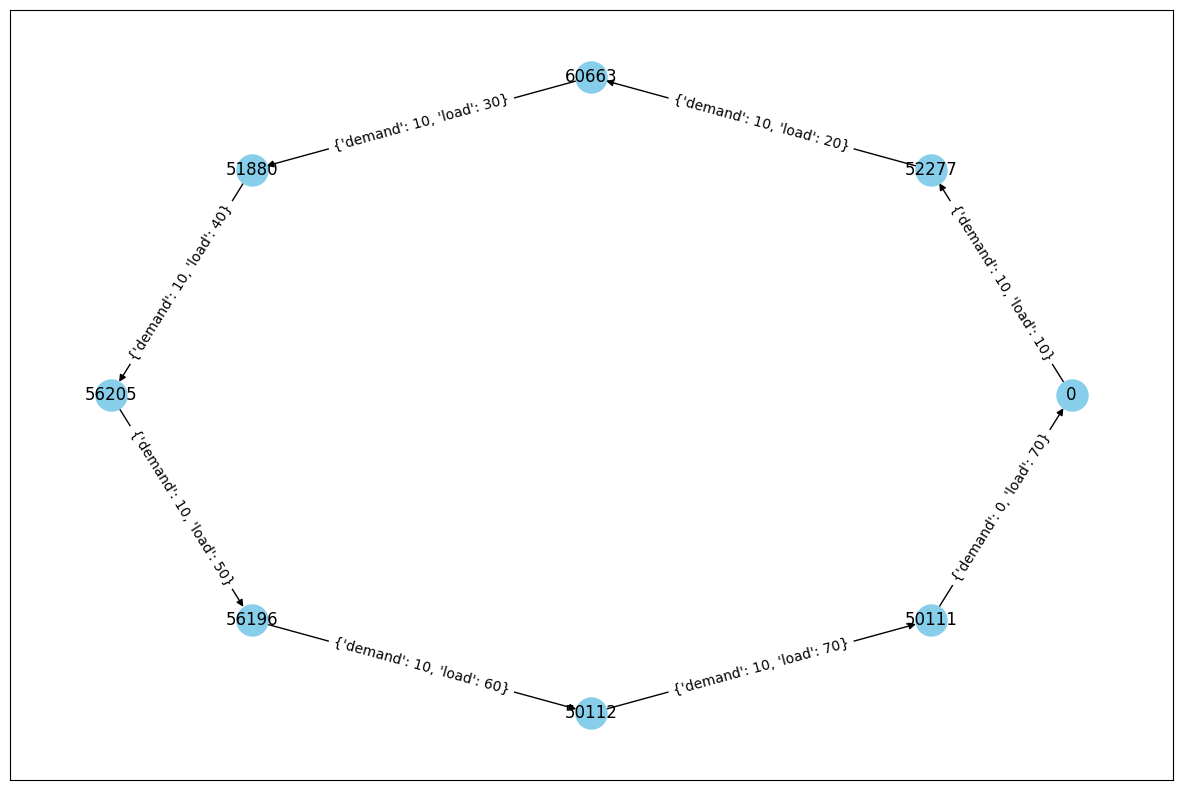



Bus 1:


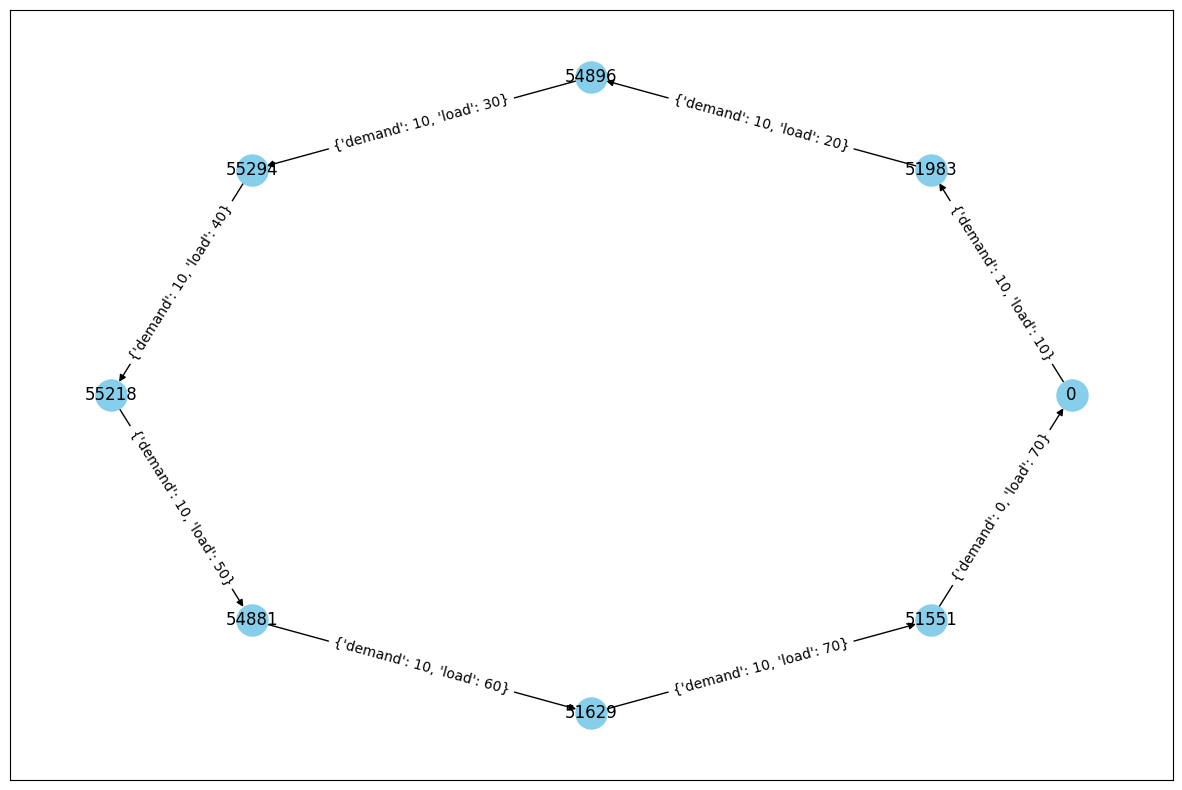



Bus 2:


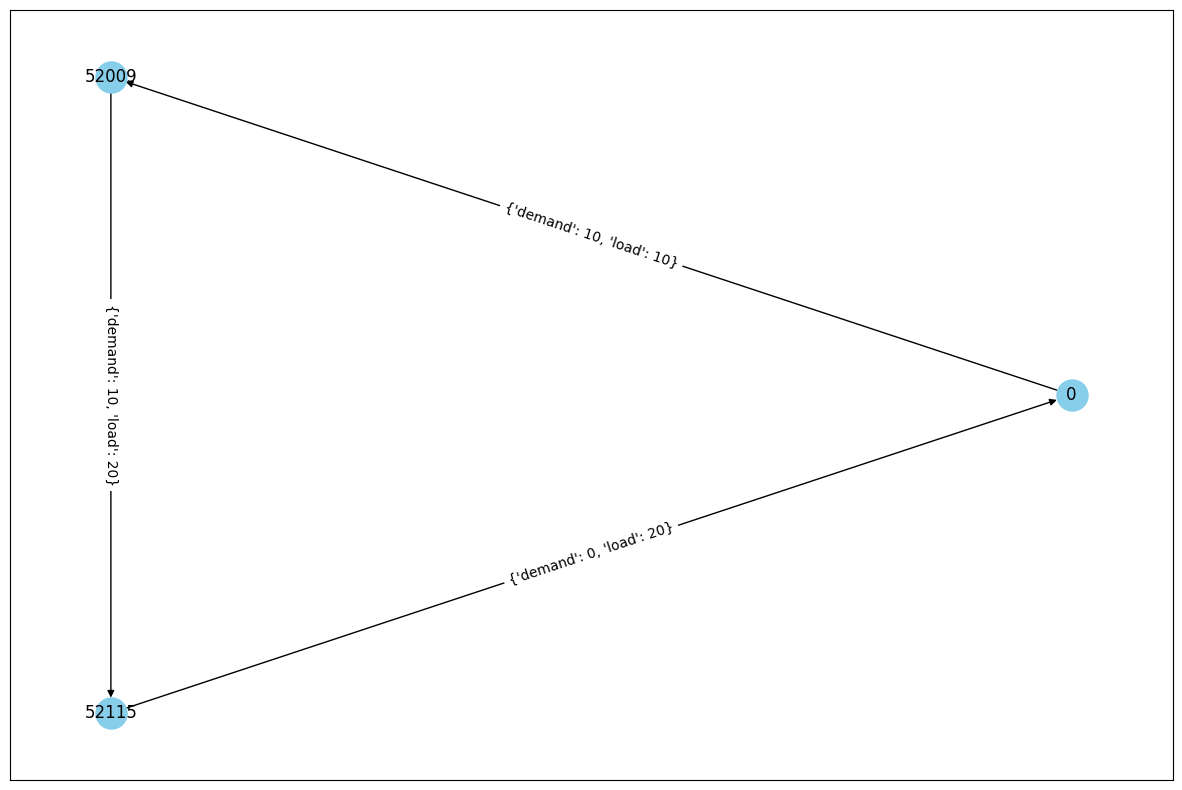



Bus 3:


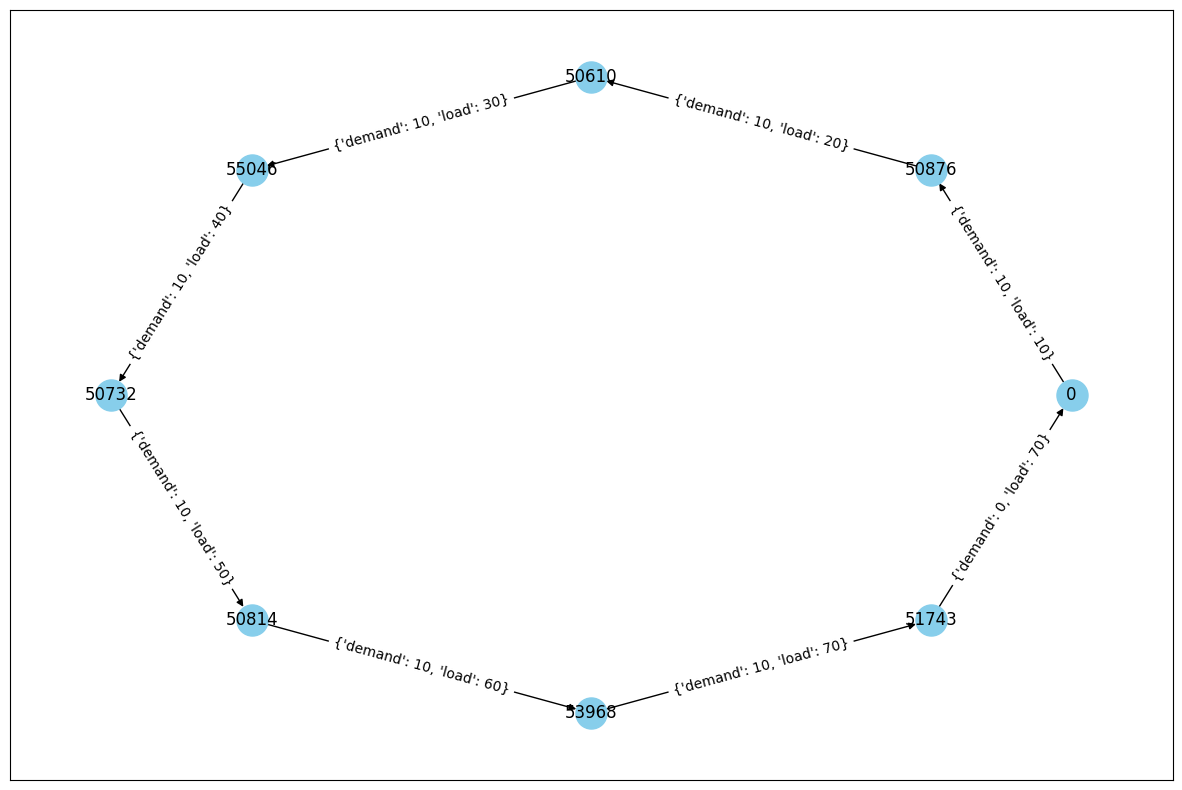



Bus 4:


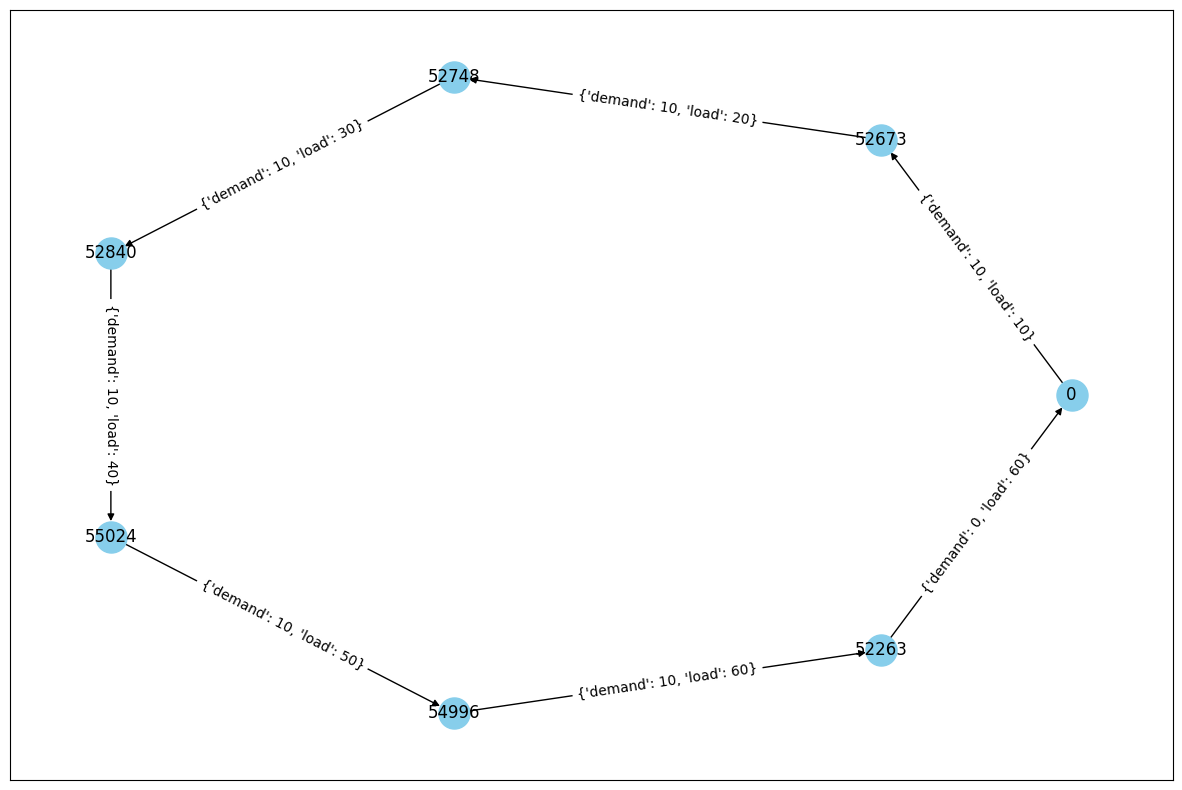



Bus 5:


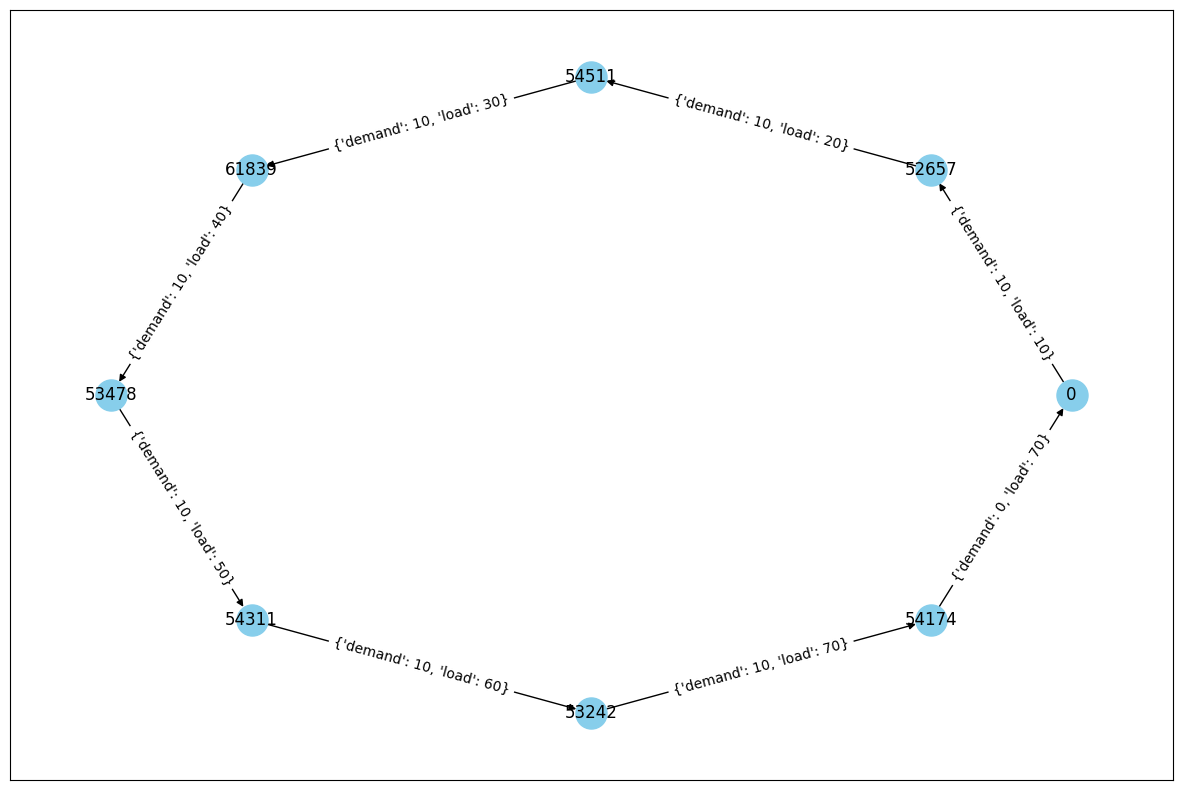



Bus 7:


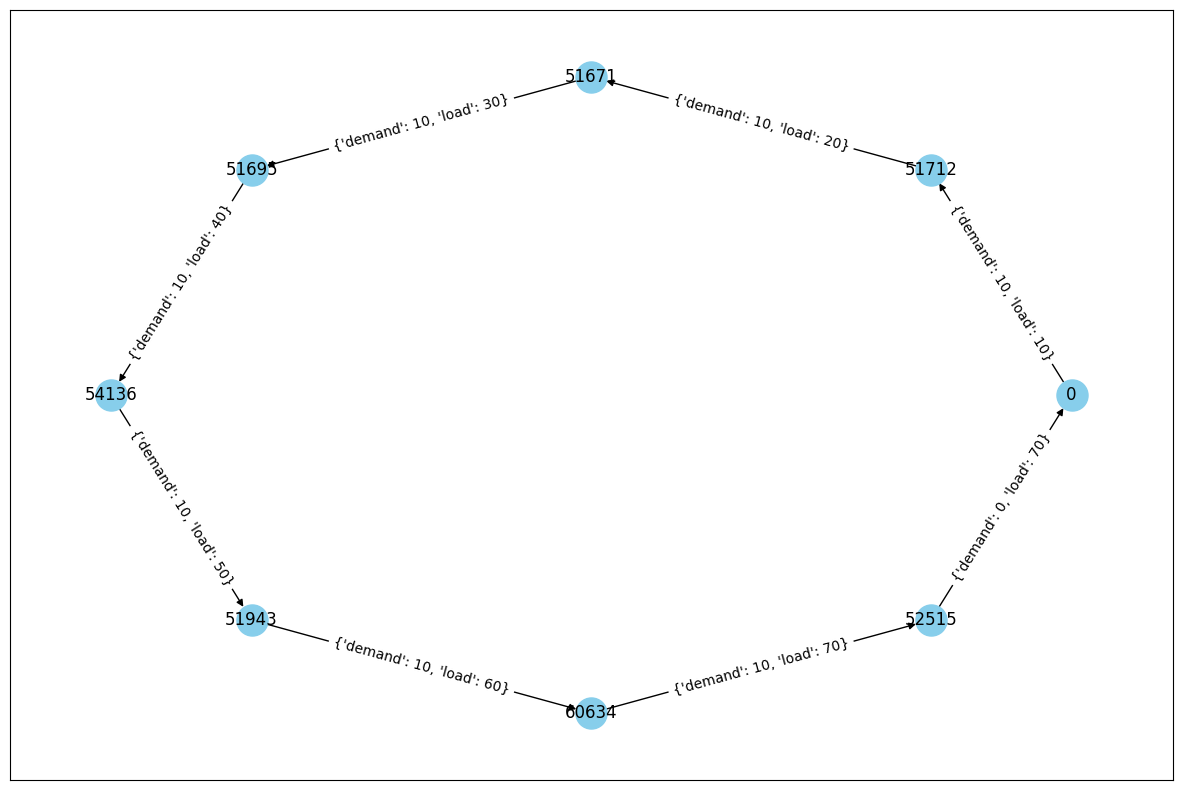



Bus 8:


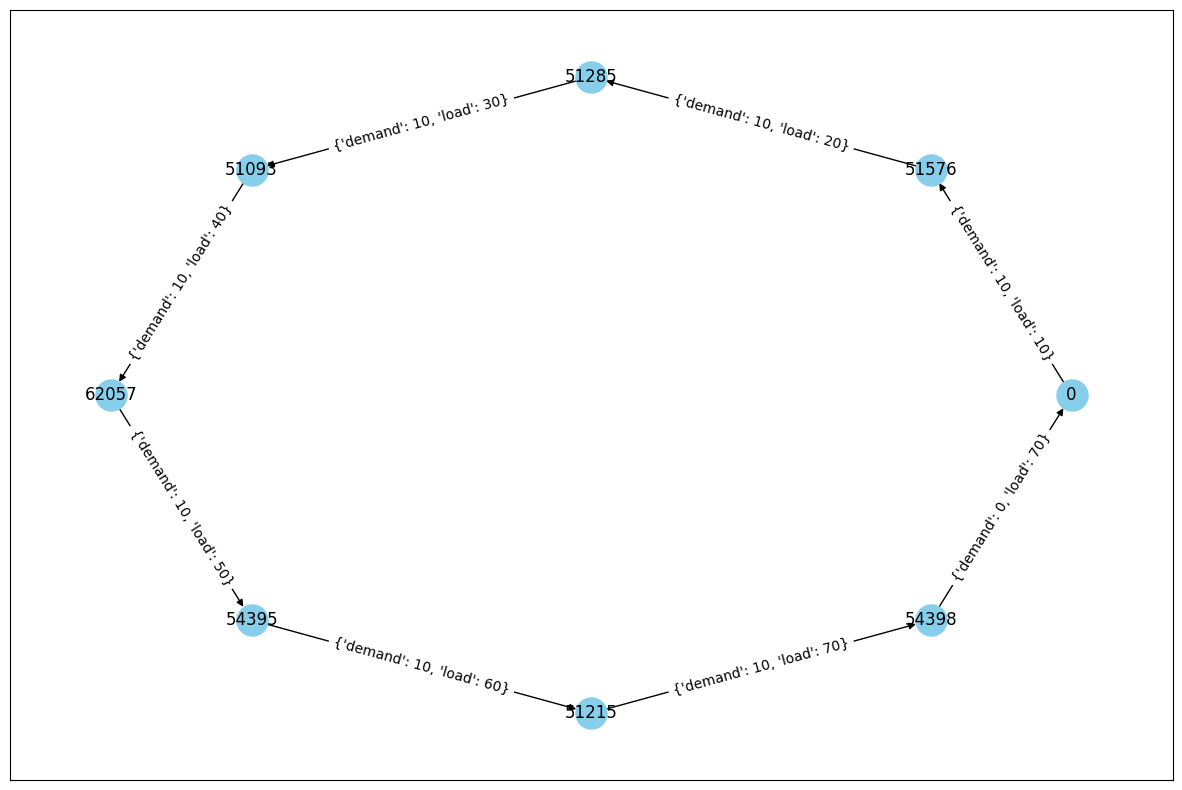



Bus 9:


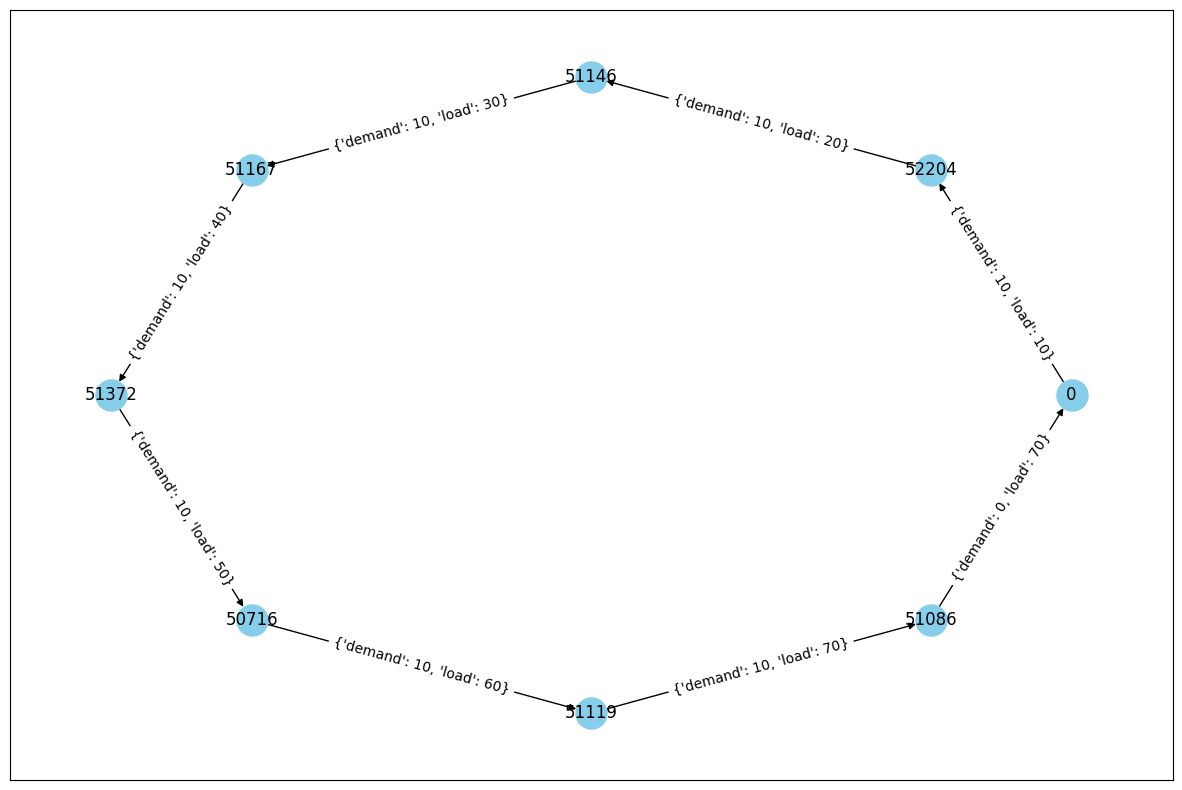

In [79]:
print(f"Number of buses used: {bus_path_df.bus.nunique()}")

for bus in bus_path_df.bus.unique():
    print(f"Bus {bus}:")

    bus_route = bus_path_df[bus_path_df["bus"] == bus].reset_index(drop=True)

    plt.figure(figsize=(15, 10))

    g = nx.DiGraph()

    for segment in bus_route.itertuples():
        g.add_edge(
            segment.start_stop,
            segment.end_stop,
            weight=segment.distance,
            demands={'demand': segment.demand, 'load': segment.step_demand},
            step=segment.step,
            label=f"{segment.start_stop}-{segment.end_stop}",
            load=segment.step_demand,
        )

    pos = nx.circular_layout(g)

    nx.draw_networkx(g, pos, with_labels=True, node_size=500, node_color="skyblue")
    # nx.draw_networkx_edge_labels(g, pos, edge_labels=nx.get_edge_attributes(g, "load"))
    nx.draw_networkx_edge_labels(g, pos, edge_labels=nx.get_edge_attributes(g, "demands"))

    plt.show()

    print("\n")

### Visualize routes to be taken by buses on a map

In [80]:
def print_optimal_paths(model, num_buses, stops):
    routes = {}

    print("Minimum distance: ", model.objVal)
    print("Optimal path for each bus: ")

    for k in range(num_buses):
        print(f"Bus {k+1}:")

        # Initialize with the depot as the starting point
        current_stop = stops[0]
        next_stop = None
        route = [current_stop]  # Start with the depot

        # Follow the path for the current bus
        while next_stop != stops[0]:
            for j in stops:
                if j != current_stop and x[current_stop, j, k].x > 0.5:
                    next_stop = j
                    route.append(next_stop)
                    current_stop = next_stop
                    break
            else:
                # If no next stop is found and we are not at the depot, it indicates an issue
                if current_stop != stops[0]:
                    print(
                        "Error: No valid next stop found. Check the model constraints."
                    )
                break

        routes[k] = route
        print(" -> ".join(map(str, route)))

    return routes

In [81]:
optimal_routes = print_optimal_paths(model, num_buses, stops)

Minimum distance:  2.100571400000007
Optimal path for each bus: 
Bus 1:
0 -> 52277 -> 60663 -> 51880 -> 56205 -> 56196 -> 50112 -> 50111 -> 0
Bus 2:
0 -> 51983 -> 54896 -> 55294 -> 55218 -> 54881 -> 51629 -> 51551 -> 0
Bus 3:
0 -> 52009 -> 52115 -> 0
Bus 4:
0 -> 50876 -> 50610 -> 55046 -> 50732 -> 50814 -> 53968 -> 51743 -> 0
Bus 5:
0 -> 52673 -> 52748 -> 52840 -> 55024 -> 54996 -> 52263 -> 0
Bus 6:
0 -> 52657 -> 54511 -> 61839 -> 53478 -> 54311 -> 53242 -> 54174 -> 0
Bus 7:
0
Bus 8:
0 -> 51712 -> 51671 -> 51695 -> 54136 -> 51943 -> 60634 -> 52515 -> 0
Bus 9:
0 -> 51576 -> 51285 -> 51093 -> 62057 -> 54395 -> 51215 -> 54398 -> 0
Bus 10:
0 -> 52204 -> 51146 -> 51167 -> 51372 -> 50716 -> 51119 -> 51086 -> 0


In [82]:
# For each optimal route, generate a GeoDataFrame with the stops and the route
def get_optimal_route_gdf(optimal_routes, stops_df_gpd):
    routes_gdf = {}

    for k, route in optimal_routes.items():
        # Add stops as GeoDataFrame with steps as index of route
        for step, stop in enumerate(route):
            stop_gdf = stops_df_gpd[stops_df_gpd["stop_id"] == stop]
            stop_gdf["step"] = step
            routes_gdf[k] = routes_gdf.get(k, pd.DataFrame()).append(stop_gdf)

    return routes_gdf


routes_gdf = get_optimal_route_gdf(optimal_routes, random_stops_df_gpd)

# add linestring of each point to the next point in the route


def get_route_lines(routes_gdf):
    route_lines = {}

    for k, route in routes_gdf.items():
        if len(route.geometry) < 2:
            continue
        route_lines[k] = {
            "route_id": k,
            "geometry": LineString(route.geometry.tolist()),
        }

    return route_lines


route_lines = gpd.GeoDataFrame(
    pd.DataFrame(get_route_lines(routes_gdf)).T.reset_index(drop=True),
    geometry="geometry",
)

In [83]:
%run route_map_config.py

In [84]:
route_map = KeplerGl(height=900)

route_map.add_data(
    data=route_lines[["route_id", "geometry"]],
    name="routes",
)

for k, route in routes_gdf.items():
    route_map.add_data(
        data=route[
            ["stop_lat", "stop_lon", "stop_id", "stop_name", "step"]
        ],
        name=f"stops_in_trip_{k}",
    )

route_map.add_data(
    data=disaster_points[["stop_lat", "stop_lon", "stop_id", "stop_name"]],
    name="disaster_points",
)

route_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'routes': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'columns': ['route_id', 'geometry'], 'data': […